# Training BiLSTM on SNLI using DFW

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/DL_project/
!pwd

Mounted at /content/drive
/content/drive/MyDrive/DL_project
/content/drive/MyDrive/DL_project


In [2]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.datasets import CIFAR100
from torch.utils.data.dataloader import DataLoader
from torchvision.transforms import *
import os
import time
import gc
import shutil
import h5py

from dfw.dfw import DFW
from dfw.dfw.losses import set_smoothing_enabled
from dfw.dfw.losses import MultiClassHingeLoss
from dfw.experiments.InferSent.data import get_nli, get_batch, build_vocab
from dfw.experiments.InferSent.models import NLINet

from snli_train_utils import *

In [3]:
GLOVE_PATH = "dfw/experiments/InferSent/dataset/GloVe/glove.840B.300d.txt"
nlipath = 'dfw/experiments/InferSent/dataset/SNLI'
train, valid, test = get_nli(nlipath)
word_vec = build_vocab(train['s1'] + train['s2'] +
                       valid['s1'] + valid['s2'] +
                       test['s1'] + test['s2'], GLOVE_PATH)

for split in ['s1', 's2']:
    for data_type in ['train', 'valid', 'test']:
        eval(data_type)[split] = np.array([['<s>'] +
            [word for word in sent.split() if word in word_vec] +
            ['</s>'] for sent in eval(data_type)[split]])


** TRAIN DATA : Found 549367 pairs of train sentences.
** DEV DATA : Found 9842 pairs of dev sentences.
** TEST DATA : Found 9824 pairs of test sentences.
Found 38957(/43479) words with glove vectors
Vocab size : 38957


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
word_emb_dim = 300
config_nli_model = {
    'n_words'        :  len(word_vec)         ,
    'word_emb_dim'   :  word_emb_dim   ,
    'enc_lstm_dim'   :  2048   ,
    'n_enc_layers'   :  1   ,
    'dpout_model'    :  0.    ,
    'dpout_fc'       :  0.       ,
    'fc_dim'         :  512         ,
    'bsize'          :  64     ,
    'n_classes'      :  3      ,
    'pool_type'      :  'max'      ,
    'nonlinear_fc'   :  0   ,
    'encoder_type'   :  'BLSTMEncoder'   ,
    'use_cuda'       :  True                  ,

}

In [ ]:
trainer = Net_Trainer(device, 'nli_dfw_snli', config_nli_model, word_vec, train, valid, test, lr=1.0, optm='dfw', loss='svm', batch_size=64, epochs=100, 
                          lr_decay=0.99, lr_shrink=5.0, weight_decay=0, mom=0, smooth=False)
best_epoch, losses, errors, accs, testacc = trainer.train()
plot_train(losses, errors, accs)
print('Best epoch:',best_epoch)
print('Test accuracy:',testacc,'%')

cuda Tesla T4
Epoch:0   Loss:0.339   Val loss:1.354   Accuracy:45.094   Best val loss:1.354   Time taken:324.687
Epoch:1   Loss:0.188   Val loss:1.248   Accuracy:47.156   Best val loss:1.248   Time taken:333.782
Epoch:2   Loss:0.151   Val loss:1.438   Accuracy:43.844   Best val loss:1.248   Time taken:331.068
Epoch:3   Loss:0.168   Val loss:1.326   Accuracy:43.609   Best val loss:1.248   Time taken:328.06
Epoch:4   Loss:0.156   Val loss:1.275   Accuracy:50.938   Best val loss:1.248   Time taken:331.373
Epoch:5   Loss:0.14   Val loss:1.258   Accuracy:49.766   Best val loss:1.248   Time taken:332.239
Epoch:6   Loss:0.146   Val loss:1.438   Accuracy:48.547   Best val loss:1.248   Time taken:334.514
Epoch:7   Loss:0.132   Val loss:1.333   Accuracy:51.484   Best val loss:1.248   Time taken:335.417
Epoch:8   Loss:0.127   Val loss:1.175   Accuracy:53.688   Best val loss:1.175   Time taken:330.917
Epoch:9   Loss:0.125   Val loss:1.204   Accuracy:53.719   Best val loss:1.175   Time taken:330.51

In [ ]:
# Conitnue training by loading checkpoint
# Best epoch = epoch with least val loss
trainer = Net_Trainer(device, 'nli_dfw_snli', config_nli_model, word_vec, train, valid, test, load_ckpt='v1_ckpt_nli_dfw_snli', lr=1.0, optm='dfw', loss='svm', batch_size=64, epochs=100, 
                          lr_decay=0.99, lr_shrink=5.0, weight_decay=0, mom=0, smooth=False)
best_epoch, losses, errors, accs, testacc = trainer.train()
plot_train(losses, errors, accs)
print('Best epoch:',best_epoch)
print('Test accuracy:',testacc,'%')

cuda Tesla T4
Epoch:30   Loss:0.103   Val loss:1.117   Accuracy:58.922   Best val loss:1.02   Time taken:340.386
Epoch:31   Loss:0.096   Val loss:1.217   Accuracy:58.297   Best val loss:1.02   Time taken:341.433
Epoch:32   Loss:0.089   Val loss:1.103   Accuracy:56.703   Best val loss:1.02   Time taken:340.224
Epoch:33   Loss:0.11   Val loss:1.184   Accuracy:54.734   Best val loss:1.02   Time taken:344.373
Epoch:34   Loss:0.1   Val loss:1.199   Accuracy:51.234   Best val loss:1.02   Time taken:340.976
Epoch:35   Loss:0.095   Val loss:1.182   Accuracy:52.859   Best val loss:1.02   Time taken:344.155
Epoch:36   Loss:0.102   Val loss:1.186   Accuracy:59.0   Best val loss:1.02   Time taken:339.629
Epoch:37   Loss:0.101   Val loss:1.174   Accuracy:51.453   Best val loss:1.02   Time taken:341.703
Epoch:38   Loss:0.091   Val loss:1.218   Accuracy:56.984   Best val loss:1.02   Time taken:339.084
Epoch:39   Loss:0.102   Val loss:1.185   Accuracy:56.094   Best val loss:1.02   Time taken:343.576
E

KeyboardInterrupt: ignored

cuda Tesla K80


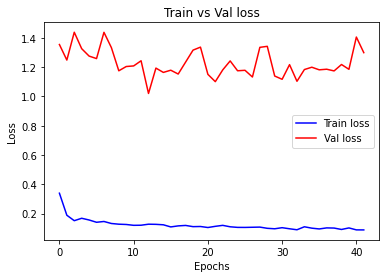

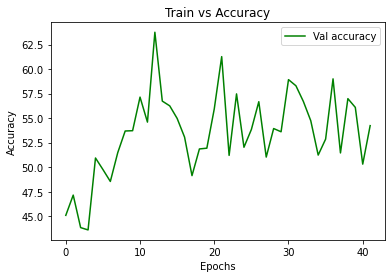

Best epoch: 12
Test accuracy: 57.859375 %


In [9]:
# This cell is used only to plot graphs till epoch 40
trainer = Net_Trainer(device, 'nli_dfw_snli', config_nli_model, word_vec, train, valid, test, load_ckpt='v1_ckpt_nli_dfw_snli_ep39', lr=1.0, optm='dfw', loss='svm', 
                      batch_size=64, epochs=40, lr_decay=0.99, lr_shrink=5.0, weight_decay=0, mom=0, smooth=False)
best_epoch, losses, errors, accs, testacc = trainer.train()
plot_train(losses, errors, accs)
print('Best epoch:',best_epoch)
print('Test accuracy:',testacc,'%')

In [5]:
best_acc = test_model(device, config_nli_model, 'v1_ckpt_nli_dfw_snli_best', test, 64, word_vec)
print('Test accuracy of best model:',best_acc)

Test accuracy of best model: 58.171875
